In [1]:
from pathlib import Path
import shutil
import random
import yaml
import subprocess
import sys
import urllib.request
import zipfile

from ultralytics.models import YOLO
import torch
from IPython.display import Image as IPImage, display
from tqdm import tqdm

In [2]:
TXT_PATH = Path("txt_output_folder")
IMG_PATH = Path("balls")
DATASET_ROOT = Path("yolo_dataset")
COCO_DIR = Path("coco_persons")
COMBINED_DATASET = Path("yolo_dataset_combined")

TRAIN_RATIO = 0.8
NUM_PERSON_IMAGES = 200
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
random.seed(42)

print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")

Device: cuda:0
GPU: NVIDIA GeForce RTX 3080 Laptop GPU
CUDA: 12.8


## Step 1: Prepare Ball Dataset

In [3]:
for split in ['train', 'val']:
    (DATASET_ROOT / split / "images").mkdir(parents=True, exist_ok=True)
    (DATASET_ROOT / split / "labels").mkdir(parents=True, exist_ok=True)

txt_files = list(TXT_PATH.glob("*.txt"))
data_pairs = []

for txt_file in txt_files:
    stem = txt_file.stem
    img_file = None
    for ext in ['.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG']:
        candidate = IMG_PATH / f"{stem}{ext}"
        if candidate.exists():
            img_file = candidate
            break
    if img_file:
        data_pairs.append((img_file, txt_file))

random.shuffle(data_pairs)
split_idx = int(len(data_pairs) * TRAIN_RATIO)
train_pairs = data_pairs[:split_idx]
val_pairs = data_pairs[split_idx:]

for img_file, txt_file in train_pairs:
    shutil.copy(img_file, DATASET_ROOT / "train" / "images" / img_file.name)
    shutil.copy(txt_file, DATASET_ROOT / "train" / "labels" / txt_file.name)

for img_file, txt_file in val_pairs:
    shutil.copy(img_file, DATASET_ROOT / "val" / "images" / img_file.name)
    shutil.copy(txt_file, DATASET_ROOT / "val" / "labels" / txt_file.name)

print(f"Ball dataset: train={len(train_pairs)}, val={len(val_pairs)}")

Ball dataset: train=567, val=142


## Step 2: Download COCO Person Data

In [4]:
from pycocotools.coco import COCO

In [5]:
COCO_DIR.mkdir(exist_ok=True)
annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
annotations_zip = COCO_DIR / "annotations_trainval2017.zip"
annotations_dir = COCO_DIR / "annotations"

if not annotations_dir.exists():
    print("Downloading COCO annotations...")
    urllib.request.urlretrieve(annotations_url, annotations_zip)
    
    with zipfile.ZipFile(annotations_zip, 'r') as zip_ref:
        zip_ref.extractall(COCO_DIR)
    print("Extraction complete")

annFile = annotations_dir / 'instances_train2017.json'
coco = COCO(str(annFile))
person_cat_id = 1

print(f"COCO annotations loaded (person category: {person_cat_id})")

loading annotations into memory...
Done (t=26.22s)
creating index...
Done (t=26.22s)
creating index...
index created!
COCO annotations loaded (person category: 1)
index created!
COCO annotations loaded (person category: 1)


In [6]:
images_dir = COCO_DIR / "images"
labels_dir = COCO_DIR / "labels"
images_dir.mkdir(exist_ok=True)
labels_dir.mkdir(exist_ok=True)

img_ids = coco.getImgIds(catIds=[person_cat_id])[:NUM_PERSON_IMAGES]
imgs = coco.loadImgs(img_ids)

print(f"Selected {len(imgs)} COCO images with persons")

def coco_segmentation_to_yolo(segmentation: list, img_width: int, img_height: int) -> list[float] | None:
    if isinstance(segmentation, list) and len(segmentation) > 0:
        polygon = segmentation[0]
        points = []
        for i in range(0, len(polygon), 2):
            x = polygon[i] / img_width
            y = polygon[i+1] / img_height
            points.extend([x, y])
        return points
    return None

downloaded = 0
for img_info in tqdm(imgs, desc="Processing"):
    img_id = img_info['id']
    img_filename = img_info['file_name']
    img_path = images_dir / img_filename
    
    if not img_path.exists():
        try:
            urllib.request.urlretrieve(img_info['coco_url'], img_path)
            downloaded += 1
        except:
            continue
    
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=[person_cat_id], iscrowd=0)
    anns = coco.loadAnns(ann_ids)
    
    label_path = labels_dir / (img_path.stem + '.txt')
    with open(label_path, 'w') as f:
        for ann in anns:
            if 'segmentation' in ann and ann['segmentation']:
                points = coco_segmentation_to_yolo(
                    ann['segmentation'], 
                    img_info['width'], 
                    img_info['height']
                )
                if points:
                    line = "1 " + " ".join([f"{p:.6f}" for p in points])
                    f.write(line + "\n")

print(f"Downloaded {downloaded} new images")

Selected 200 COCO images with persons


Processing: 100%|██████████| 200/200 [00:00<00:00, 1280.47it/s]

Downloaded 0 new images


## Step 3: Combine Datasets

In [7]:
for split in ['train', 'val']:
    (COMBINED_DATASET / split / "images").mkdir(parents=True, exist_ok=True)
    (COMBINED_DATASET / split / "labels").mkdir(parents=True, exist_ok=True)

for split in ['train', 'val']:
    src_imgs = DATASET_ROOT / split / "images"
    src_labels = DATASET_ROOT / split / "labels"
    dst_imgs = COMBINED_DATASET / split / "images"
    dst_labels = COMBINED_DATASET / split / "labels"
    
    for img_file in src_imgs.glob("*.jpg"):
        shutil.copy(img_file, dst_imgs / img_file.name)
        label_file = src_labels / (img_file.stem + '.txt')
        if label_file.exists():
            shutil.copy(label_file, dst_labels / label_file.name)

coco_images = list(images_dir.glob("*.jpg"))
random.shuffle(coco_images)

split_idx = int(len(coco_images) * 0.8)
train_coco = coco_images[:split_idx]
val_coco = coco_images[split_idx:]

for img_file in train_coco:
    shutil.copy(img_file, COMBINED_DATASET / "train" / "images" / img_file.name)
    label_file = labels_dir / (img_file.stem + '.txt')
    if label_file.exists():
        shutil.copy(label_file, COMBINED_DATASET / "train" / "labels" / label_file.name)

for img_file in val_coco:
    shutil.copy(img_file, COMBINED_DATASET / "val" / "images" / img_file.name)
    label_file = labels_dir / (img_file.stem + '.txt')
    if label_file.exists():
        shutil.copy(label_file, COMBINED_DATASET / "val" / "labels" / label_file.name)

yaml_data = {
    'path': str(COMBINED_DATASET.absolute()),
    'train': 'train/images',
    'val': 'val/images',
    'nc': 2,
    'names': {0: 'ball', 1: 'person'}
}

yaml_path = COMBINED_DATASET / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_data, f, default_flow_style=False)

train_total = len(list((COMBINED_DATASET / 'train' / 'images').glob('*.jpg')))
val_total = len(list((COMBINED_DATASET / 'val' / 'images').glob('*.jpg')))
print(f"Combined dataset: train={train_total}, val={val_total}")

Combined dataset: train=761, val=216


## Step 4: Training

In [20]:
project_name = "ball_person_model_head_only"

In [ ]:
model = YOLO('yolo11n-seg.pt')

head_idx = next((i for i, m in enumerate(model.model.model) if 'Detect' in m.__class__.__name__ or 'Segment' in m.__class__.__name__), len(model.model.model) - 1)
print(f"Head starts at layer: {head_idx}")
print(f"Freezing layers: 0-{head_idx-1}")

results = model.train(
    data=str(yaml_path),
    freeze=list(range(head_idx)),
    epochs=10,
    imgsz=640,
    batch=8,
    device=DEVICE,
    project='runs/segment',
    name=project_name,
    exist_ok=True,
    pretrained=True,
    optimizer='Adam',
    lr0=0.001,
    patience=15,
    save=True,
    save_period=5,
    plots=True,
    workers=0,
    val=False,
    hsv_h=0.01,
    hsv_s=0.5,
    hsv_v=0.3,
    degrees=5.0,
    translate=0.1,
    scale=0.3,
    flipud=0.0,
    fliplr=0.5,
    mosaic=0.5
)

print(f"Model saved: runs/segment/ball_person_model/weights/best.pt")

Head starts at layer: 23
Freezing layers: 0-22
Ultralytics 8.3.235 🚀 Python-3.12.10 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 8192MiB)
Ultralytics 8.3.235 🚀 Python-3.12.10 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 8192MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset_combined/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], half=False, hsv_h=0.01, hsv_s=0.5, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, ma

## Step 5: Load Trained Model

Execute this cell to load the trained model (without retraining)

In [ ]:
model_path = Path('runs/segment') / project_name / "weights"/ "best.pt"

if model_path.exists():
    model = YOLO(str(model_path))
    print(f"Model loaded: {model_path}")
else:
    print(f"Model not found: {model_path}")
    print("Run training cell first")

Model loaded: runs/segment/ball_person_model_head_only/weights/best.pt


## Step 6: Validation

In [12]:
metrics = model.val(
    data=str(yaml_path),
    batch=8,
    workers=0,
    device=DEVICE
)

print(f"Box - mAP50: {metrics.box.map50:.4f}, mAP50-95: {metrics.box.map:.4f}")
print(f"Mask - mAP50: {metrics.seg.map50:.4f}, mAP50-95: {metrics.seg.map:.4f}")

for i, name in enumerate(['ball', 'person']):
    if i < len(metrics.seg.ap50):
        print(f"{name}: mAP50={metrics.seg.ap50[i]:.4f}, mAP50-95={metrics.seg.ap[i]:.4f}")

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 2.5it/s 10.6s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 2.5it/s 10.6s
                   all        216        467      0.876      0.785      0.843      0.723      0.877      0.782      0.838      0.661
                  ball        142        142      0.948      0.986       0.99      0.956      0.948      0.986       0.99      0.917
                person         74        325      0.803      0.585      0.696       0.49      0.806      0.578      0.686      0.406
Speed: 0.5ms preprocess, 11.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to /home/tonino/projects/ball segmentation/runs/segment/val5
Box - mAP50: 0.8430, mAP50-95: 0.7228
Mask - mAP50: 0.8382, mAP50-95: 0.6614
ball: mAP50=0.9904

In [ ]:
# test_images = list((COMBINED_DATASET / "val" / "images").glob("*.jpg"))

# if len(test_images) > 0:
#     test_img = test_images[0]
    
    
#     results = model.predict(
#         source=str(test_img),
#         save=True,
#         conf=0.25,
#         iou=0.5,
#         device=DEVICE,
#         show_labels=True,
#         show_conf=True,
#         project='runs/segment',
#         name='predictions',
#         exist_ok=True
#     )
    
#     for r in results:
#         if r.boxes is not None and len(r.boxes) > 0:
#             ball_count = sum(1 for cls in r.boxes.cls if int(cls) == 0)
#             person_count = sum(1 for cls in r.boxes.cls if int(cls) == 1)
            
#             print(f"Detected: {ball_count} ball(s), {person_count} person(s)")
            
#             for i, (box, cls) in enumerate(zip(r.boxes.xyxy, r.boxes.cls)):
#                 class_name = 'ball' if int(cls) == 0 else 'person'
#                 conf = r.boxes.conf[i]
#                 print(f"  {class_name}: {conf:.3f}")
            
#             pred_path = Path('runs/segment/predictions') / test_img.name
#             if pred_path.exists():
#                 display(IPImage(filename=str(pred_path), width=800))

results.png:


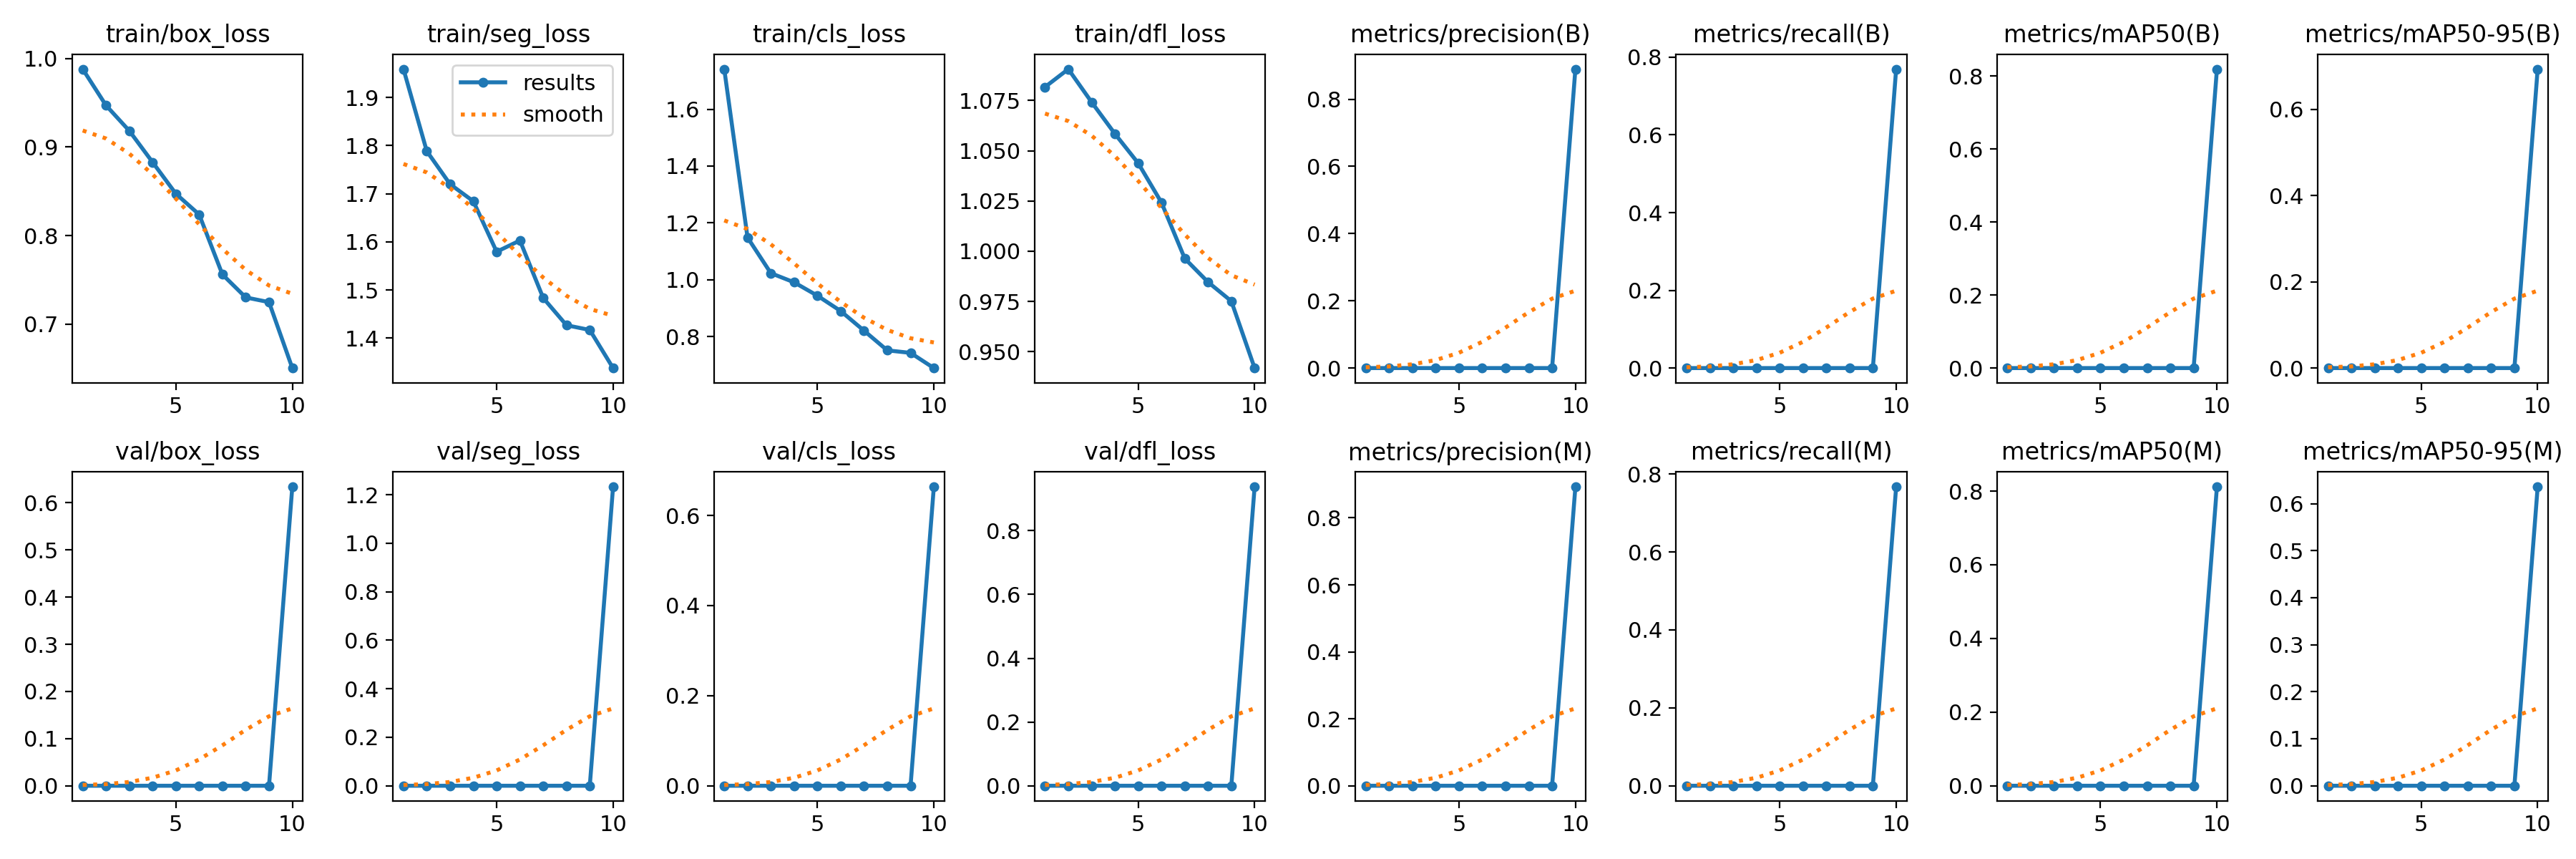

confusion_matrix.png:


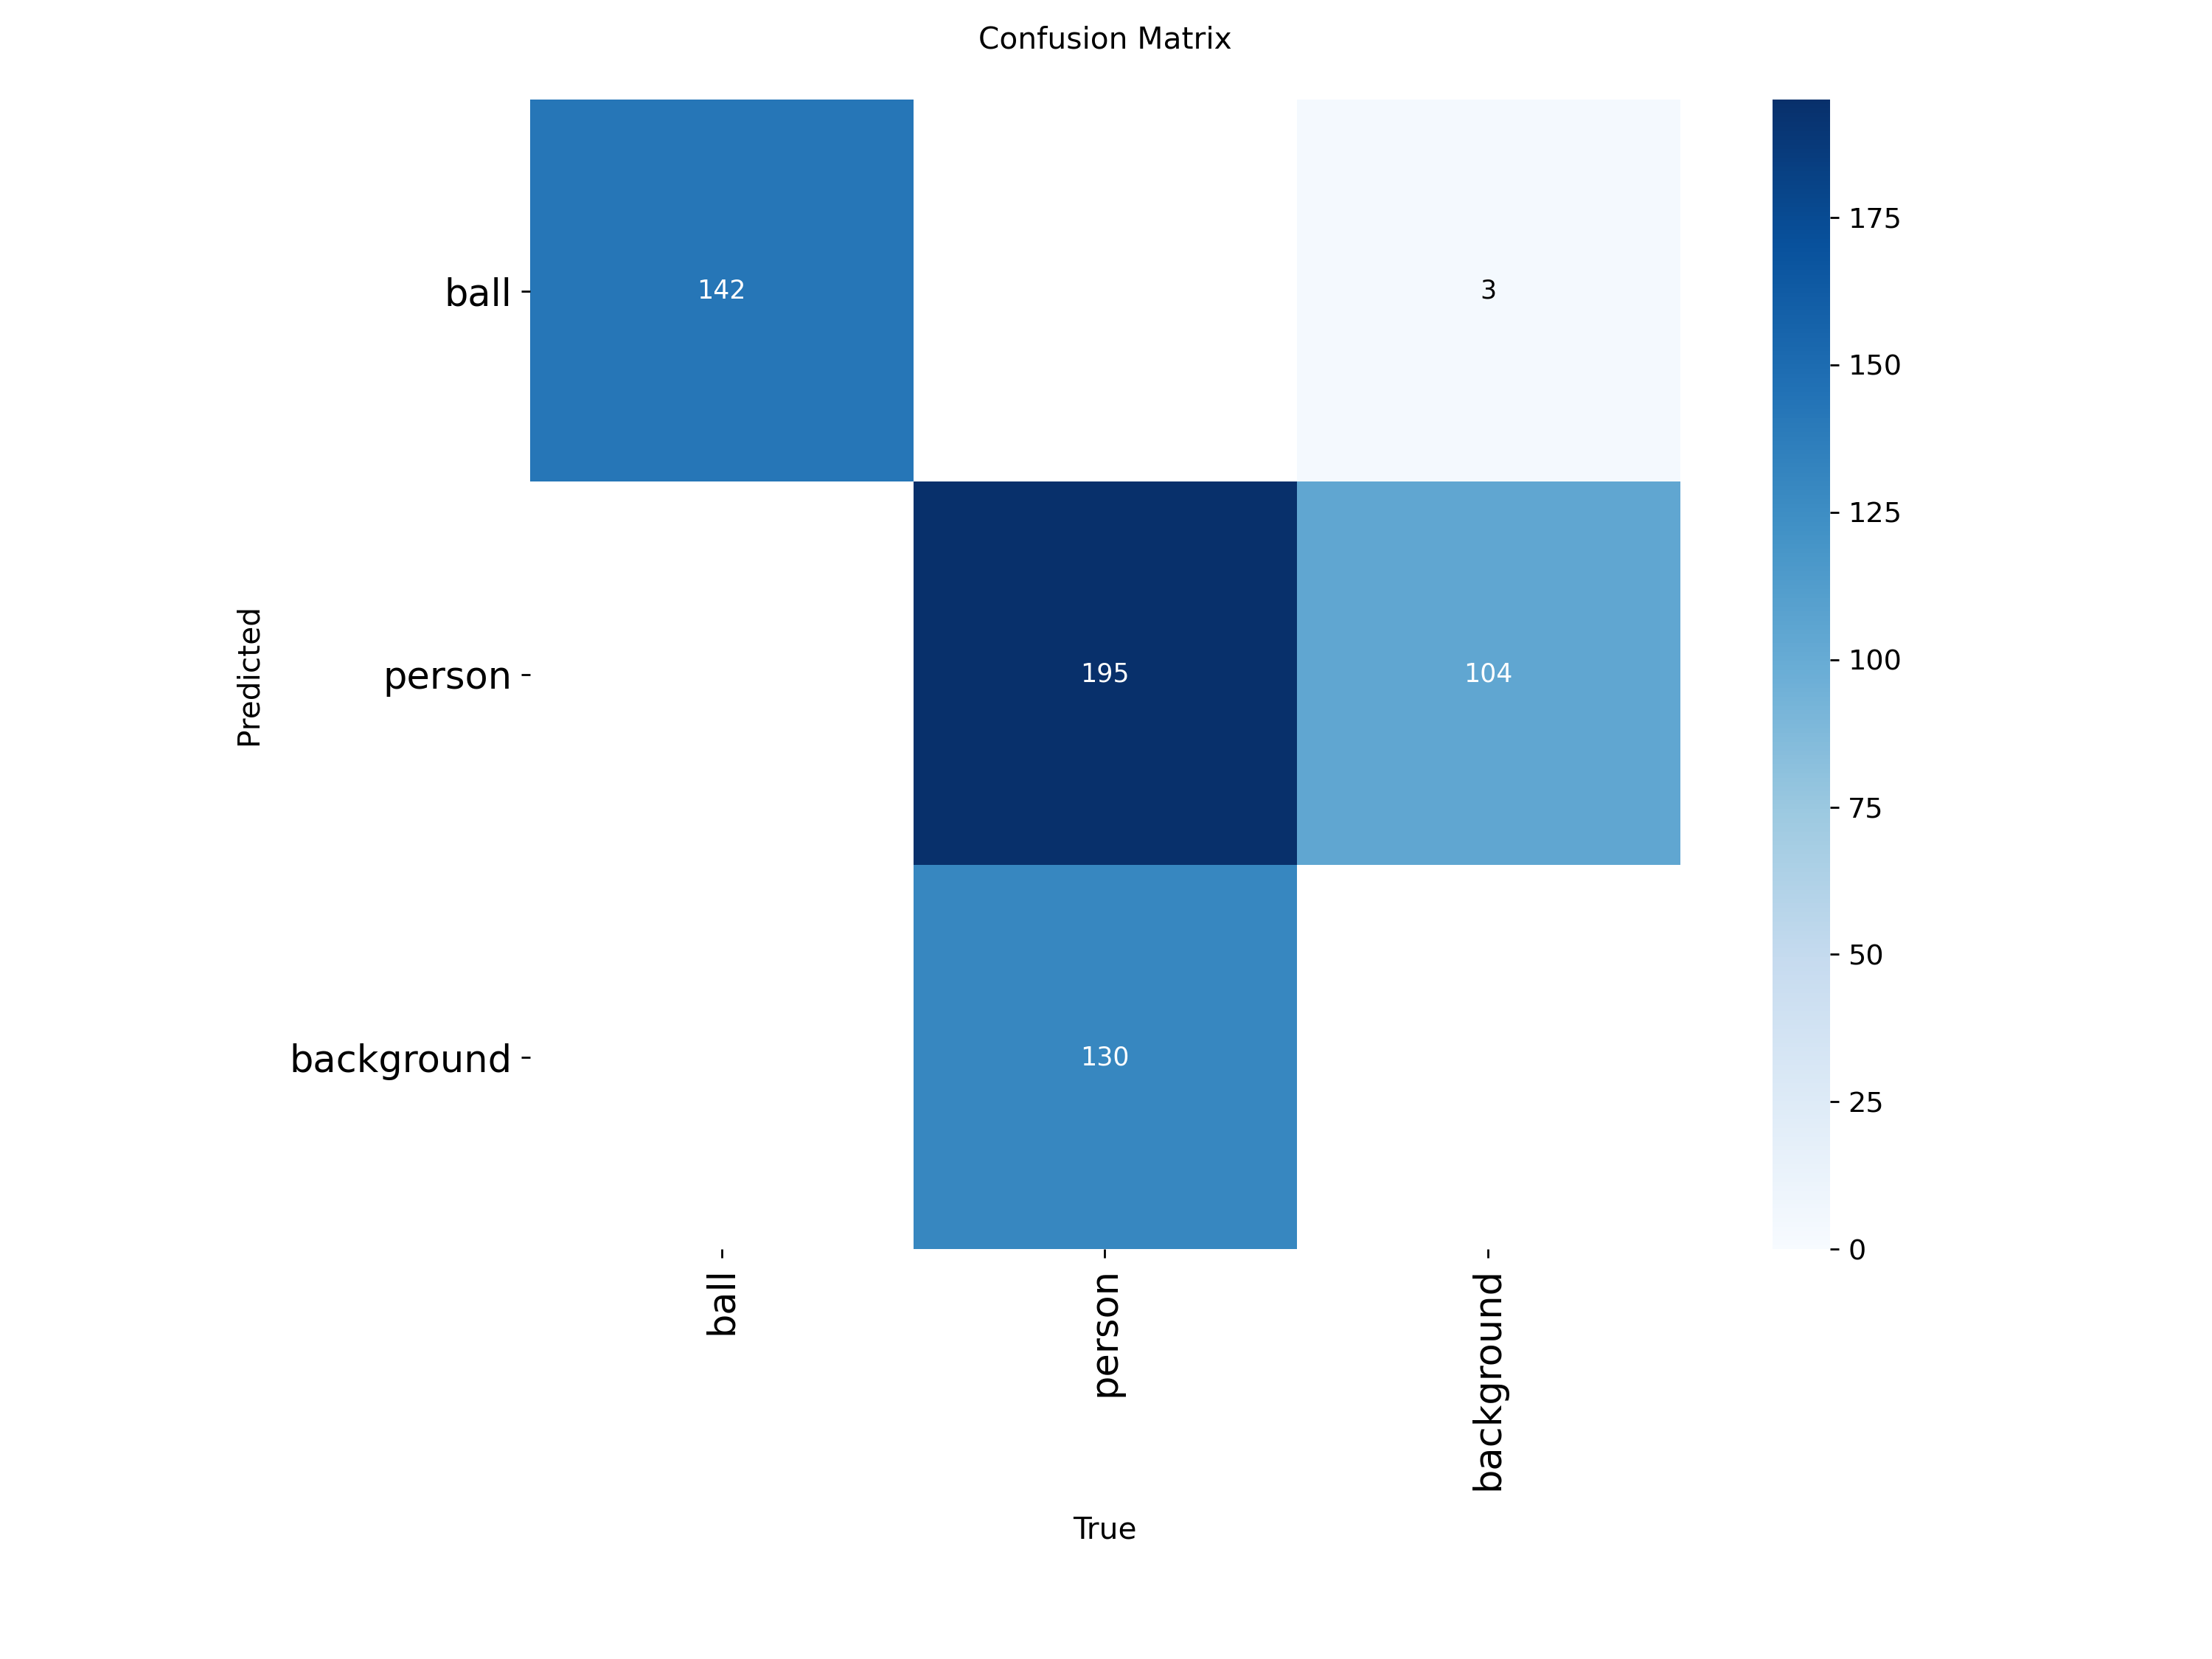

val_batch0_labels.jpg:


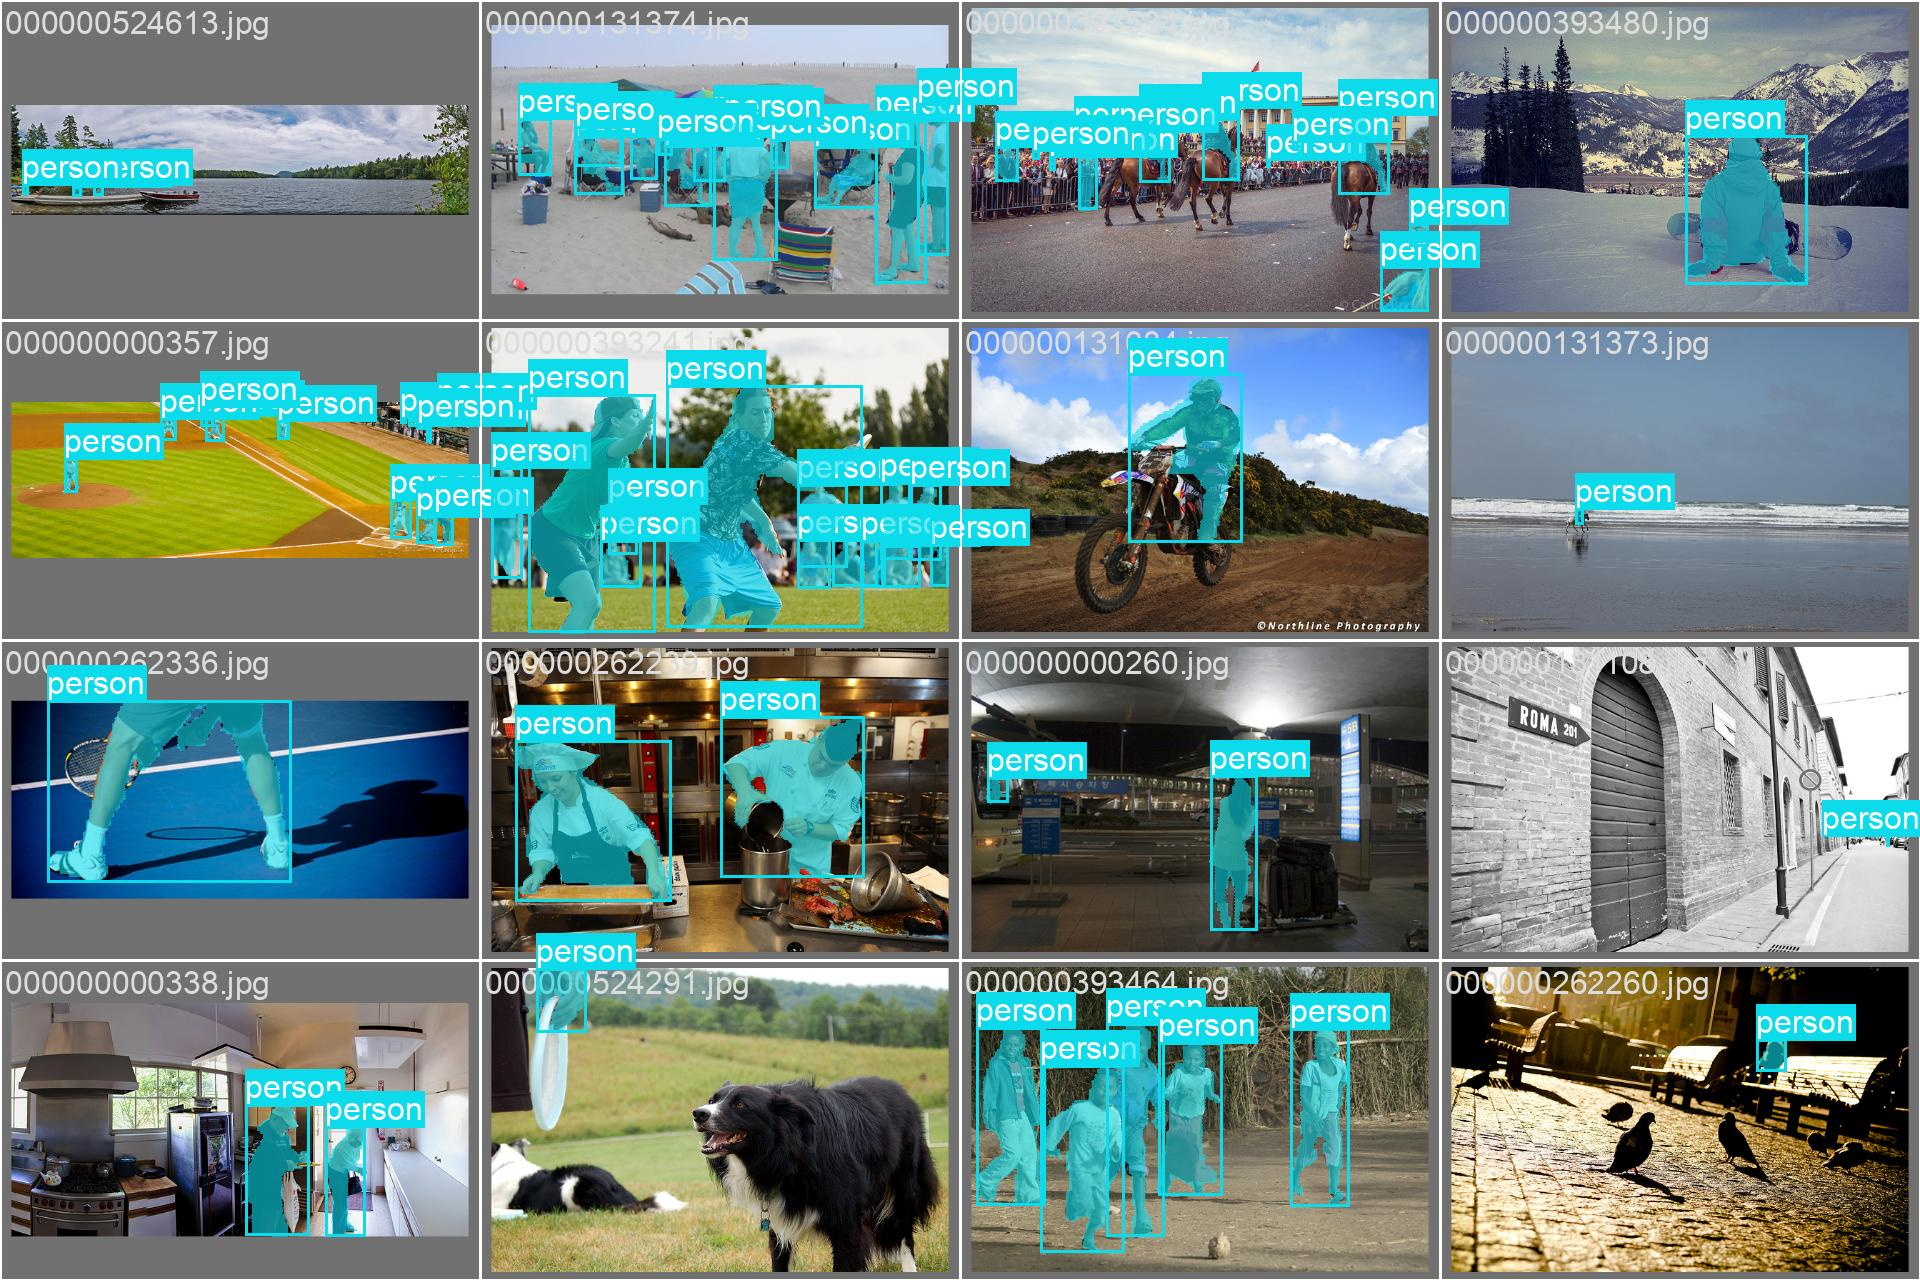

val_batch0_pred.jpg:


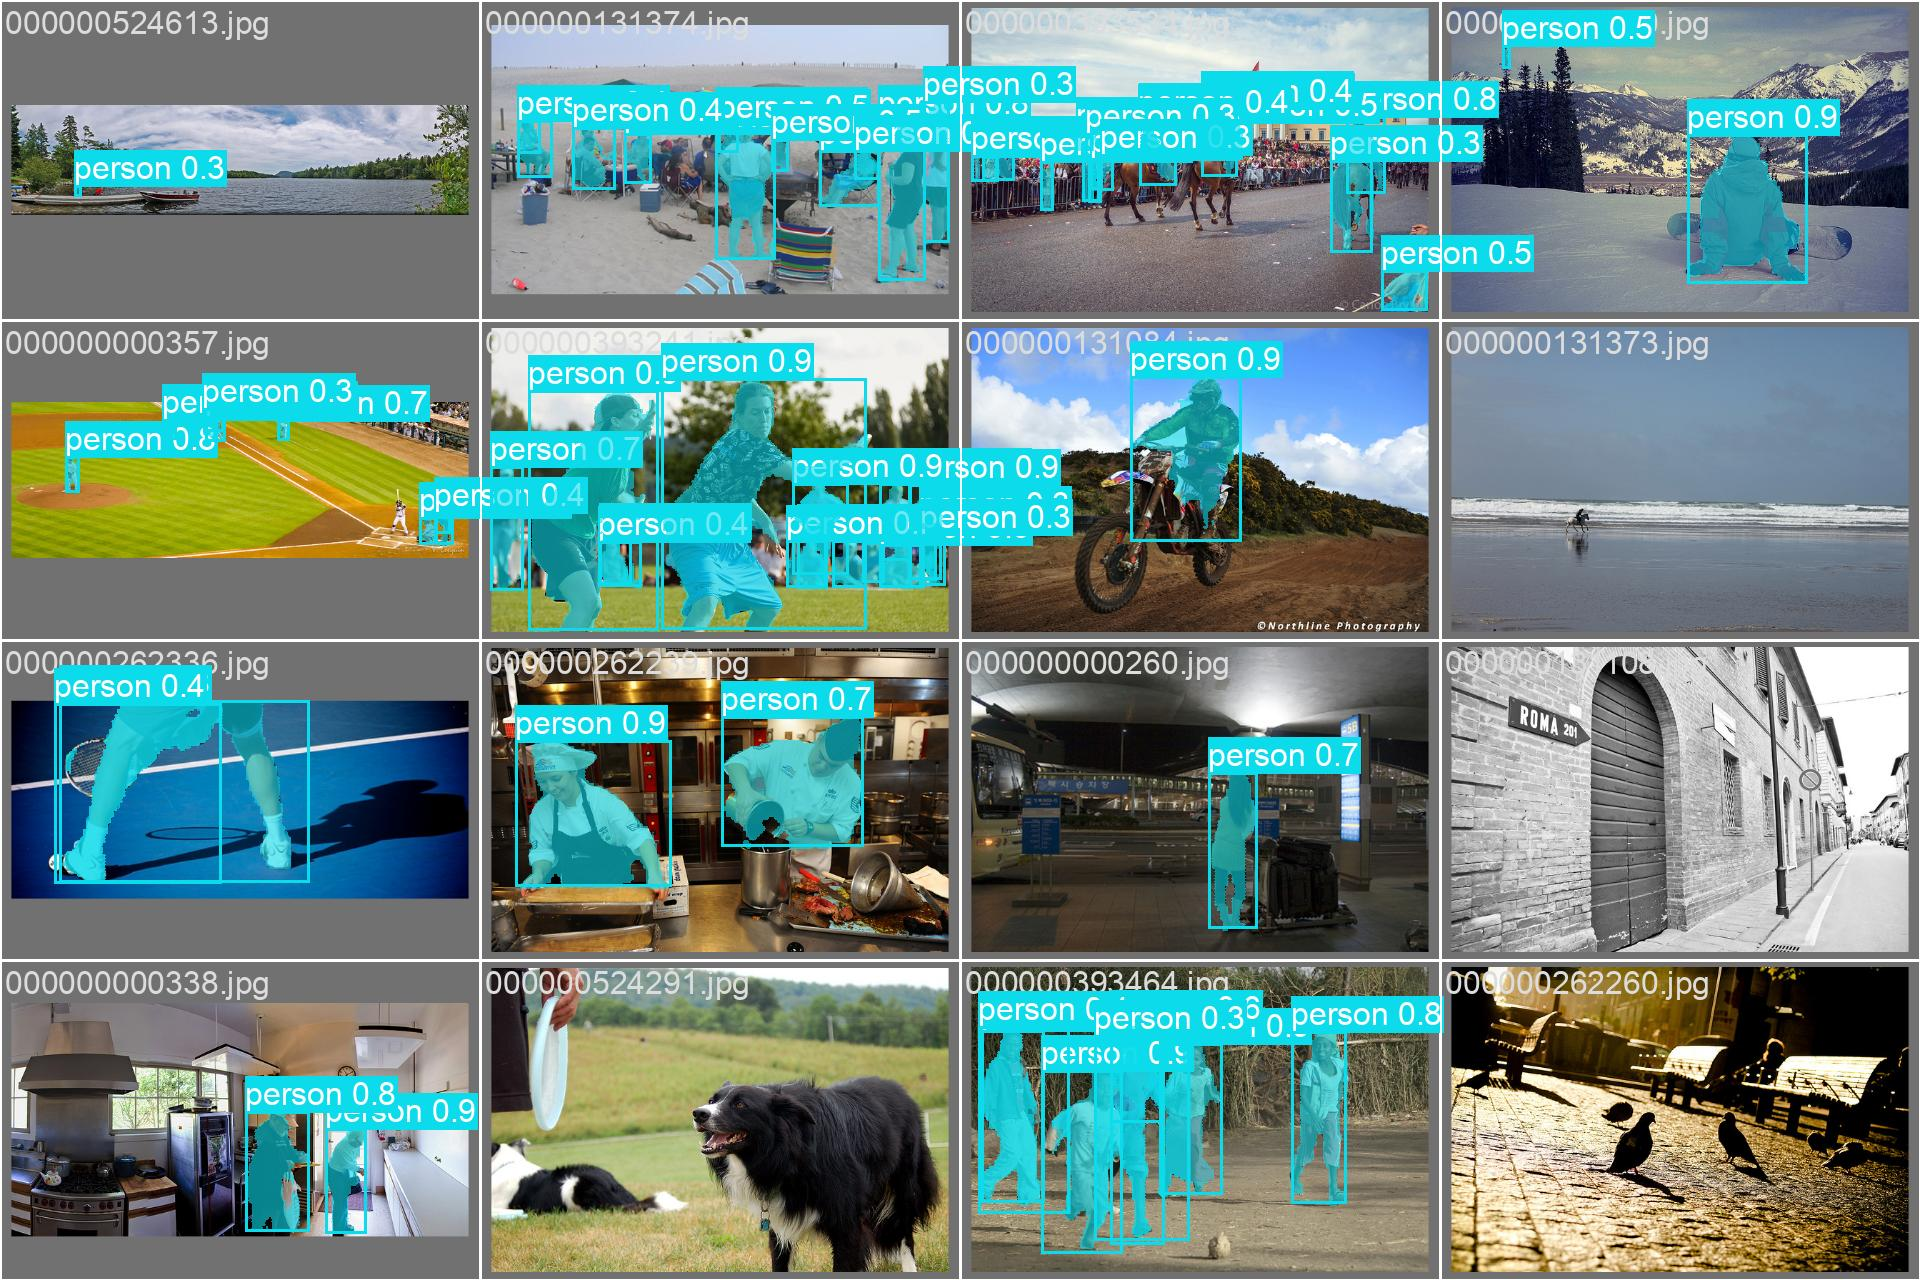

In [14]:
results_dir = Path('runs/segment/ball_person_model')

if results_dir.exists():
    plots = ['results.png', 'confusion_matrix.png', 'val_batch0_labels.jpg', 'val_batch0_pred.jpg']
    
    for plot in plots:
        plot_path = results_dir / plot
        if plot_path.exists():
            print(f"{plot}:")
            display(IPImage(filename=str(plot_path), width=800))

## Test on Manual Validation Image

In [18]:
from time import perf_counter

In [21]:
def visualize_img(img_path: Path):
    test_manual_img = img_path
    
    start = perf_counter()
    results = model.predict(
        source=str(test_manual_img),
        save=True,
        conf=0.25,
        iou=0.5,
        device=DEVICE,
        show_labels=True,
        show_conf=True,
        project='runs/segment',
        name='manual_validation_pred',
        exist_ok=True
    )
    
    for r in results:
        if r.boxes is not None and len(r.boxes) > 0:
            ball_count = sum(1 for cls in r.boxes.cls if int(cls) == 0)
            person_count = sum(1 for cls in r.boxes.cls if int(cls) == 1)
            
            print(f"Detected: {ball_count} ball(s), {person_count} person(s)")
            
            for i, (box, cls) in enumerate(zip(r.boxes.xyxy, r.boxes.cls)):
                class_name = 'ball' if int(cls) == 0 else 'person'
                conf = r.boxes.conf[i]
                print(f"  {class_name}: {conf:.3f}")
            
            pred_path = Path('runs/segment/manual_validation_pred') / test_manual_img.name
            if pred_path.exists():
                display(IPImage(filename=str(pred_path), width=800))
        else:
            print("No detections")
        
    return perf_counter() - start

In [16]:
img_paths = list(Path("df").glob("*.jpg"))

In [ ]:
exec_times = []
for img_path in img_paths:
    exec_times.append(visualize_img(img_path))

In [23]:
avg = sum(exec_times) / len(exec_times)
avg

0.5127531378127514


image 1/1 /home/tonino/projects/ball segmentation/df/valid.jpg: 640x480 1 ball, 1 person, 98.7ms
Speed: 14.2ms preprocess, 98.7ms inference, 14.3ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /home/tonino/projects/ball segmentation/runs/segment/manual_validation_pred
image 1/1 /home/tonino/projects/ball segmentation/df/valid.jpg: 640x480 1 ball, 1 person, 98.7ms
Speed: 14.2ms preprocess, 98.7ms inference, 14.3ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /home/tonino/projects/ball segmentation/runs/segment/manual_validation_pred
Detected: 1 ball(s), 1 person(s)
  person: 0.938
  ball: 0.751
Detected: 1 ball(s), 1 person(s)
  person: 0.938
  ball: 0.751


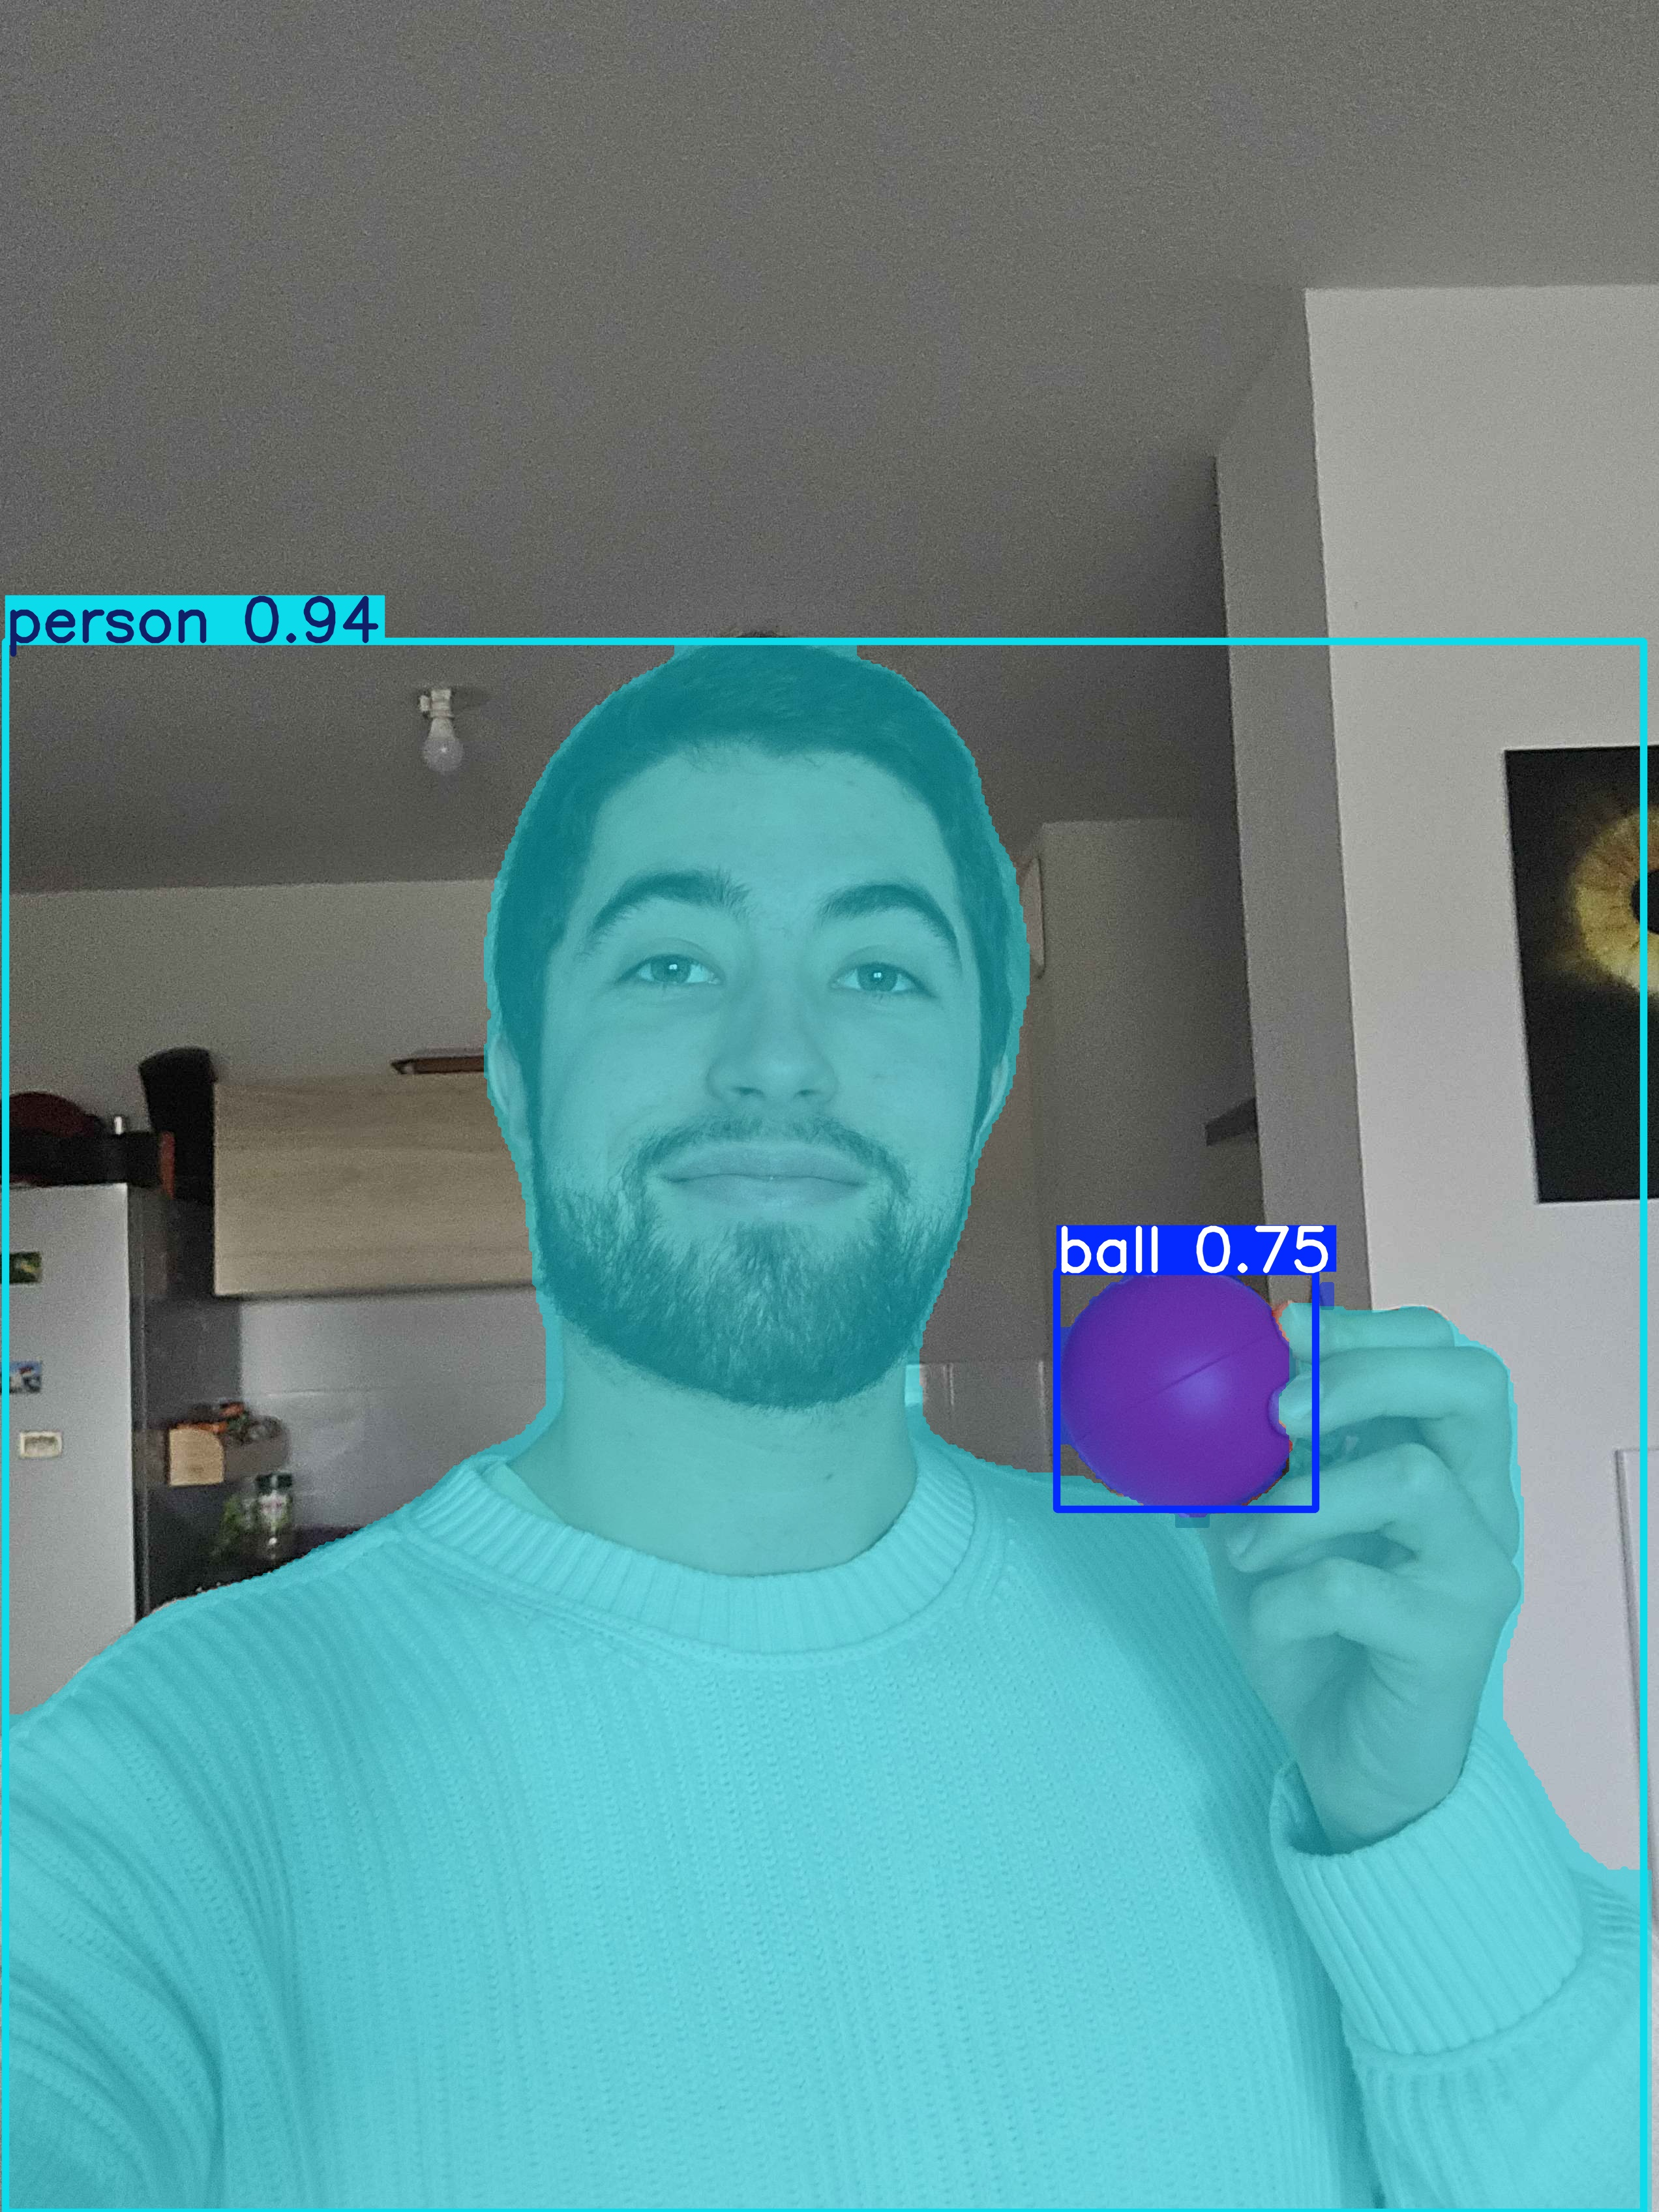

In [19]:
visualize_img(Path("df")/ "valid.jpg")